# Neural Networks For Market Trading

In [1]:
import pandas as pd
df = pd.read_csv("/Users/veddarji0108/Downloads/CODING/EURUSD_Candlestick_1_D_ASK_05.05.2003-30.06.2021.csv")

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Local time,open,high,low,close,volume
4729,24.06.2021 00:00:00.000 GMT+0300,1.19267,1.19565,1.19178,1.19322,85152.21000
4730,25.06.2021 00:00:00.000 GMT+0300,1.19322,1.19754,1.19264,1.19392,77837.64500
4731,28.06.2021 00:00:00.000 GMT+0300,1.19380,1.19447,1.19025,1.19260,85154.26000
4732,29.06.2021 00:00:00.000 GMT+0300,1.19297,1.19334,1.18779,1.18973,98898.57000
4733,30.06.2021 00:00:00.000 GMT+0300,1.18973,1.19092,1.18452,1.18589,4301.30191


# Support and Resistance FUNCTIONS

In [2]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [3]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [4]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [5]:
df['signal']=signal

In [6]:
df[df['signal']==1].count()

Local time    91
open          91
high          91
low           91
close         91
volume        91
signal        91
dtype: int64

In [7]:
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
#df=df.iloc[100:200]
df

,Local time,Open,High,Low,Close,Volume,signal
0,05.05.2003 00:00:00.000 GMT+0300,1.12354,1.13019,1.12030,1.12804,1.053163e+06,0
1,06.05.2003 00:00:00.000 GMT+0300,1.12798,1.14510,1.12738,1.14368,1.061123e+06,0
2,07.05.2003 00:00:00.000 GMT+0300,1.14367,1.14448,1.13275,1.13677,1.056797e+06,0
3,08.05.2003 00:00:00.000 GMT+0300,1.13675,1.15092,1.13026,1.15026,1.058909e+06,0
4,09.05.2003 00:00:00.000 GMT+0300,1.15002,1.15376,1.14362,1.14907,1.063989e+06,0
...,...,...,...,...,...,...,...
4729,24.06.2021 00:00:00.000 GMT+0300,1.19267,1.19565,1.19178,1.19322,8.515221e+04,0
4730,25.06.2021 00:00:00.000 GMT+0300,1.19322,1.19754,1.19264,1.19392,7.783765e+04,0
4731,28.06.2021 00:00:00.000 GMT+0300,1.19380,1.19447,1.19025,1.19260,8.515426e+04,0
4732,29.06.2021 00:00:00.000 GMT+0300,1.19297,1.19334,1.18779,1.18973,9.889857e+04,0


In [8]:
def SIGNAL():
    return df.signal

In [9]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [10]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [11]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



/var/folders/44/5fjpmy5x6kg9yc3gslmc0bww0000gn/T/ipykernel_23203/1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                    4733.0
Duration                               4733.0
Exposure Time [%]                   72.327841
Equity Final [$]                   22652.5528
Equity Peak [$]                   23157.25094
Return [%]                         126.525528
Buy & Hold Return [%]                5.128364
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -18.92864
Avg. Drawdown [%]                   -1.851858
Max. Drawdown Duration                 1242.0
Avg. Drawdown Duration              45.131868
# Trades                                 94.0
Win Rate [%]                        75.531915
Best Trade [%]                       4.225471
Worst Trade [%]                     -5.511457
Avg. Trade [%]                    

In [17]:
bt.plot()

/opt/anaconda3/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/anaconda3/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1678', ...)

In [13]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

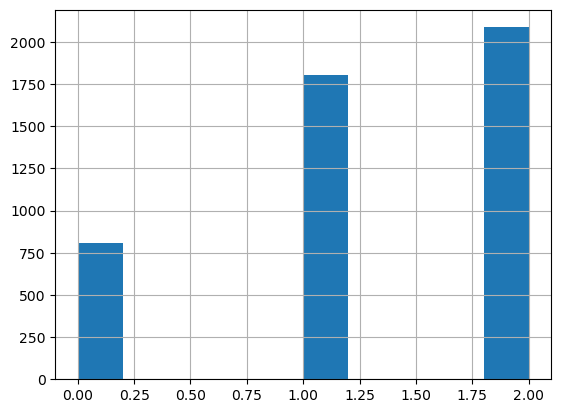

In [14]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [15]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Local time,Open,High,Low,Close,Volume,signal,Target,RSI
4714,03.06.2021 00:00:00.000 GMT+0300,1.22110,1.22145,1.21185,1.21286,88254.06500,0,NaN,49.477636
4715,04.06.2021 00:00:00.000 GMT+0300,1.21286,1.21859,1.21042,1.21692,93227.20000,0,NaN,52.951303
4716,07.06.2021 00:00:00.000 GMT+0300,1.21653,1.22020,1.21451,1.21900,54728.21500,0,NaN,54.655028
4717,08.06.2021 00:00:00.000 GMT+0300,1.21900,1.21944,1.21645,1.21738,89944.55750,0,NaN,53.058818
4718,09.06.2021 00:00:00.000 GMT+0300,1.21735,1.22182,1.21715,1.21827,58199.15500,0,NaN,53.848674
4719,10.06.2021 00:00:00.000 GMT+0300,1.21827,1.21949,1.21436,1.21759,90672.80000,0,NaN,53.120221
4720,11.06.2021 00:00:00.000 GMT+0300,1.21763,1.21932,1.20928,1.21096,66907.59500,0,NaN,46.568547
4721,14.06.2021 00:00:00.000 GMT+0300,1.21105,1.21307,1.20944,1.21211,52083.78350,0,NaN,47.760622
4722,15.06.2021 00:00:00.000 GMT+0300,1.21215,1.21475,1.21014,1.21273,65038.75000,0,NaN,48.422366
4723,16.06.2021 00:00:00.000 GMT+0300,1.21270,1.21350,1.19946,1.19952,100176.68500,0,NaN,37.598105


In [18]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

              Open         High          Low        Close        Volume  \
count  4686.000000  4686.000000  4686.000000  4686.000000  4.686000e+03   
mean      1.256384     1.261742     1.250856     1.256416  5.062613e+05   
std       0.120442     0.121224     0.119504     0.120421  4.501105e+05   
min       1.038960     1.041820     1.034050     1.038980  1.500000e+00   
25%       1.149282     1.154012     1.144473     1.149263  1.828032e+05   
50%       1.250490     1.256425     1.244320     1.250465  2.562193e+05   
75%       1.341700     1.346760     1.335892     1.341370  8.018746e+05   
max       1.599500     1.604030     1.586560     1.599120  2.230654e+06   

            signal       Target          RSI  
count  4686.000000  4686.000000  4686.000000  
mean      0.053564     1.269740    50.457756  
std       0.291302     0.736754    11.351599  
min       0.000000     0.000000    16.961494  
25%       0.000000     1.000000    42.633442  
50%       0.000000     1.000000    50.5341

In [19]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,73.535348,1.0,True,False,False
1,67.160049,1.0,True,False,False
2,71.964013,1.0,True,False,False
3,62.550133,1.0,True,False,False
4,60.927262,1.0,True,False,False
...,...,...,...,...,...
4681,60.749877,1.0,False,True,False
4682,53.453470,0.0,False,True,False
4683,54.090333,0.0,True,False,False
4684,58.756972,1.0,True,False,False


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 58.8720%
****Test Results****
Accuracy: 30.5832%


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[   4  109  156]
 [   1  759  673]
 [   0  410 1168]]
[[  1 204 336]
 [  0 125 244]
 [  1 191 304]]
              precision    recall  f1-score   support

         0.0       0.80      0.01      0.03       269
         1.0       0.59      0.53      0.56      1433
         2.0       0.58      0.74      0.65      1578

    accuracy                           0.59      3280
   macro avg       0.66      0.43      0.41      3280
weighted avg       0.61      0.59      0.56      3280

              precision    recall  f1-score   support

         0.0       0.50      0.00      0.00       541
         1.0       0.24      0.34      0.28       369
         2.0       0.34      0.61      0.44       496

    accuracy                           0.31      1406
   macro avg       0.36      0.32      0.24      1406
weighted avg       0.38      0.31      0.23      1406

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


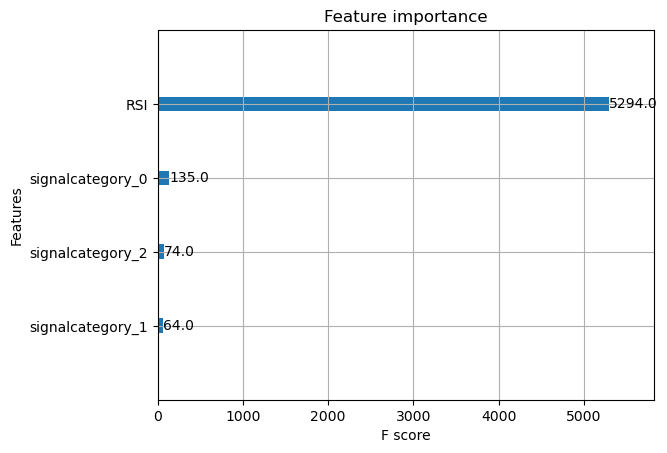

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [22]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [23]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 52.8637%
****Test Results****
Accuracy: 34.9867%


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[   0    6  183]
 [   0   76 1088]
 [   0   48 1410]]
[[  0  10 611]
 [  0  82 556]
 [  0  42 574]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       189
         1.0       0.58      0.07      0.12      1164
         2.0       0.53      0.97      0.68      1458

    accuracy                           0.53      2811
   macro avg       0.37      0.34      0.27      2811
weighted avg       0.51      0.53      0.40      2811

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       621
         1.0       0.61      0.13      0.21       638
         2.0       0.33      0.93      0.49       616

    accuracy                           0.35      1875
   macro avg       0.31      0.35      0.23      1875
weighted avg       0.32      0.35      0.23      1875



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/